In [ ]:
# ============================================================
# ETL TRANSFORM PHASE - DSA 2040A FS 2025
# Student: Peter [ID: ***341]
# Dataset: Superstore Sales (Kaggle)
# Purpose: Apply >=5 transformations, show before/after, save outputs
# ============================================================

# === 1. Imports ===
import pandas as pd
import numpy as np
from datetime import timedelta

# === 2. File paths (adjusted to your environment) ===
RAW_PATH = 'C:/Users/kidig/OneDrive/Desktop/ET_Exam_Peter_341/Data/raw_data.csv'
INC_PATH = 'C:/Users/kidig/OneDrive/Desktop/ET_Exam_Peter_341/Data/incremental_data.csv'
OUT_FULL = 'C:/Users/kidig/OneDrive/Desktop/ET_Exam_Peter_341/Transformed/transformed_full.csv'
OUT_INC  = 'C:/Users/kidig/OneDrive/Desktop/ET_Exam_Peter_341/Transformed/transformed_incremental.csv'

# Create output folder if it doesn't exist (pure Python - works in notebook)
import os
os.makedirs(os.path.dirname(OUT_FULL), exist_ok=True)

# === 3. Load datasets ===
# Read CSVs using a permissive decoding strategy to avoid UnicodeDecodeError.
# Try UTF-8 first and fall back to latin-1 if that fails.
try:
    raw_df = pd.read_csv(RAW_PATH, encoding='utf-8')
except UnicodeDecodeError:
    raw_df = pd.read_csv(RAW_PATH, encoding='latin-1')

try:
    inc_df = pd.read_csv(INC_PATH, encoding='utf-8')
except UnicodeDecodeError:
    inc_df = pd.read_csv(INC_PATH, encoding='latin-1')

print("Loaded:")
print(" - raw:", raw_df.shape)
print(" - incremental:", inc_df.shape)

# Quick display for "before" snapshots
print("\n--- RAW BEFORE ---")
display(raw_df.head(3))
print(raw_df.dtypes)

# === 4. Define transformation function (applies same pipeline to any df) ===
def transform_df(df, show_examples=True):
    df = df.copy()  # don't modify original
    
    # ---------- Transformation 1: Standardize date fields ----------
    # Convert Order Date and Ship Date to datetime (Standardization)
    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
    df['Ship Date']  = pd.to_datetime(df['Ship Date'], errors='coerce')
    
    # Show if any coerced to NaT
    if show_examples:
        print("\nAfter date conversion: Order Date NaT =", df['Order Date'].isna().sum(),
              ", Ship Date NaT =", df['Ship Date'].isna().sum())
    
    # ---------- Transformation 2: Enrichment - Shipping Duration ----------
    # Create Shipping_Duration (in days) = Ship Date - Order Date
    df['Shipping_Duration_days'] = (df['Ship Date'] - df['Order Date']).dt.days
    
    # Replace negative or missing durations with NaN (could be data issues)
    df.loc[df['Shipping_Duration_days'] < 0, 'Shipping_Duration_days'] = np.nan
    
    # ---------- Transformation 3: Enrichment - Profit Margin ----------
    # Profit margin as Profit / Sales (handle Sales == 0)
    df['Profit_Margin'] = np.where(df['Sales'] == 0, np.nan, df['Profit'] / df['Sales'])
    
    # ---------- Transformation 4: Structural - Postal Code as string ----------
    # Postal codes may have leading zeros; convert to str and zero-pad if needed
    df['Postal Code'] = df['Postal Code'].astype(str).str.strip()
    
    # If you want 5-digit format (optional), uncomment and adjust:
    # df['Postal Code'] = df['Postal Code'].str.zfill(5)
    
    # ---------- Transformation 5: Cleaning - Trim whitespace, fix case for text ----------
    text_cols = ['Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country',
                 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Order ID']
    for c in text_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()
    
    # ---------- Transformation 6: Categorization - Sales Tier ----------
    # Create Sales_Tier bins (Low, Medium, High) using quantiles (categorization)
    try:
        q25, q75 = df['Sales'].quantile([0.25, 0.75])
        bins = [-np.inf, q25, q75, np.inf]
        labels = ['Low', 'Medium', 'High']
        df['Sales_Tier'] = pd.cut(df['Sales'], bins=bins, labels=labels)
    except Exception as e:
        df['Sales_Tier'] = np.nan
    
    # ---------- Transformation 7: Structural - Convert some columns to 'category' dtype ----------
    cat_cols = ['Ship Mode', 'Segment', 'Country', 'Region', 'Category', 'Sub-Category', 'Sales_Tier']
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype('category')
    
    # ---------- Transformation 8: Cleaning - Remove exact duplicate rows ----------
    before_dup = df.shape[0]
    df = df.drop_duplicates(ignore_index=True)
    after_dup = df.shape[0]
    # (No aggressive row filtering here — keep it safe)
    
    # ---------- Optional: Create derived column 'Revenue_per_Item' ----------
    # If we treat 'Sales' divided by 'Quantity' as approximate unit revenue
    df['Revenue_per_Item'] = np.where(df['Quantity'] == 0, np.nan, df['Sales'] / df['Quantity'])
    
    # Reset index
    df = df.reset_index(drop=True)
    
    # Return transformed dataframe and a small summary dict
    summary = {
        'rows_before_duplicates': before_dup,
        'rows_after_duplicates': after_dup
    }
    return df, summary

# === 5. Apply transformation to raw and incremental datasets ===
trans_raw, raw_summary = transform_df(raw_df, show_examples=True)
trans_inc, inc_summary = transform_df(inc_df, show_examples=False)

print("\nTransform summaries:")
print(" - raw duplicates removed:", raw_summary['rows_before_duplicates'] - raw_summary['rows_after_duplicates'])
print(" - inc duplicates removed:", inc_summary['rows_before_duplicates'] - inc_summary['rows_after_duplicates'])

# === 6. Show BEFORE vs AFTER for key columns (raw dataset) ===
print("\n--- BEFORE (raw) sample ---")
display(raw_df.loc[:, ['Order Date','Ship Date','Shipping_Duration_days']] .head(3) if 'Shipping_Duration_days' in raw_df.columns else raw_df.loc[:, ['Order Date','Ship Date']].head(3))
print("\n--- AFTER (raw) sample ---")
display(trans_raw.loc[:, ['Order Date','Ship Date','Shipping_Duration_days','Profit_Margin','Sales_Tier']].head(5))

# Data types after transformation
print("\n--- Data types after transform (raw) ---")
print(trans_raw.dtypes)

# === 7. Quick sanity checks / aggregations (to show transformation effects) ===
print("\nCount by Sales_Tier (raw):")
display(trans_raw['Sales_Tier'].value_counts(dropna=False))

print("\nShipping Duration stats (raw):")
display(trans_raw['Shipping_Duration_days'].describe())

print("\nProfit margin stats (raw):")
display(trans_raw['Profit_Margin'].describe())

# === 8. Filtering example - remove rows with null Order Date (if any) ===
before_filter = trans_raw.shape[0]
trans_raw = trans_raw[~trans_raw['Order Date'].isna()].reset_index(drop=True)
after_filter = trans_raw.shape[0]
print(f"\nFiltered {before_filter - after_filter} rows with missing Order Date (if any).")

# === 9. Save transformed outputs ===
trans_raw.to_csv(OUT_FULL, index=False)
trans_inc.to_csv(OUT_INC, index=False)
print(f"\n✅ Transformed files saved:\n - {OUT_FULL}\n - {OUT_INC}")

# === 10. Notebook-friendly summary (Markdown-like printout) ===
print("\n--- TRANSFORM PHASE SUMMARY ---")
print(f"Input raw rows: {raw_df.shape[0]} -> Output (transformed) rows: {trans_raw.shape[0]}")
print(f"Input incremental rows: {inc_df.shape[0]} -> Output (transformed) rows: {trans_inc.shape[0]}")
print("Transformations applied (examples):")
print(" 1) Convert Order Date & Ship Date -> datetime")
print(" 2) Create Shipping_Duration_days = Ship Date - Order Date")
print(" 3) Create Profit_Margin = Profit / Sales")
print(" 4) Postal Code -> string; trimmed textual fields")
print(" 5) Sales_Tier (Low/Medium/High) via quantiles")
print(" 6) Convert categorical columns to category dtype")
print(" 7) Revenue_per_Item = Sales / Quantity")
print("All transformations are deterministic and the notebook is re-runnable.")


Loaded:
 - raw: (8996, 21)
 - incremental: (998, 21)

--- RAW BEFORE ---


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7981,CA-2014-103800,2014-01-03,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
1,740,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2,741,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748


Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

After date conversion: Order Date NaT = 0 , Ship Date NaT = 0

Transform summaries:
 - raw duplicates removed: 0
 - inc duplicates removed: 0

--- BEFORE (raw) sample ---


,Order Date,Ship Date
0,2014-01-03,1/7/2014
1,2014-01-04,1/8/2014
2,2014-01-04,1/8/2014



--- AFTER (raw) sample ---


,Order Date,Ship Date,Shipping_Duration_days,Profit_Margin,Sales_Tier
0,2014-01-03,2014-01-07,4.0,0.3375,Low
1,2014-01-04,2014-01-08,4.0,0.3625,Low
2,2014-01-04,2014-01-08,4.0,-0.2375,High
3,2014-01-04,2014-01-08,4.0,-1.5500,Low
4,2014-01-05,2014-01-12,7.0,0.2500,Medium



--- Data types after transform (raw) ---
Row ID                             int64
Order ID                          object
Order Date                datetime64[ns]
Ship Date                 datetime64[ns]
Ship Mode                       category
Customer ID                       object
Customer Name                     object
Segment                         category
Country                         category
City                              object
State                             object
Postal Code                       object
Region                          category
Product ID                        object
Category                        category
Sub-Category                    category
Product Name                      object
Sales                            float64
Quantity                           int64
Discount                         float64
Profit                           float64
Shipping_Duration_days           float64
Profit_Margin                    float64
Sales_Tier     

Sales_Tier
Medium    4501
Low       2249
High      2246
Name: count, dtype: int64


Shipping Duration stats (raw):


count    8996.000000
mean        3.961094
std         1.744502
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: Shipping_Duration_days, dtype: float64


Profit margin stats (raw):


count    8996.000000
mean        0.120245
std         0.467507
min        -2.750000
25%         0.075000
50%         0.270000
75%         0.362500
max         0.500000
Name: Profit_Margin, dtype: float64


Filtered 0 rows with missing Order Date (if any).

✅ Transformed files saved:
 - C:/Users/kidig/OneDrive/Desktop/ET_Exam_Peter_341/Transformed/transformed_full.csv
 - C:/Users/kidig/OneDrive/Desktop/ET_Exam_Peter_341/Transformed/transformed_incremental.csv

--- TRANSFORM PHASE SUMMARY ---
Input raw rows: 8996 -> Output (transformed) rows: 8996
Input incremental rows: 998 -> Output (transformed) rows: 998
Transformations applied (examples):
 1) Convert Order Date & Ship Date -> datetime
 2) Create Shipping_Duration_days = Ship Date - Order Date
 3) Create Profit_Margin = Profit / Sales
 4) Postal Code -> string; trimmed textual fields
 5) Sales_Tier (Low/Medium/High) via quantiles
 6) Convert categorical columns to category dtype
 7) Revenue_per_Item = Sales / Quantity
All transformations are deterministic and the notebook is re-runnable.


🧩 Transformation Overview

In this phase, several data transformation operations were performed to clean, standardize, enrich, and categorize the dataset.
The goal was to prepare the data for analysis by ensuring consistency, deriving new insights, and improving its usability.

A total of 7 transformations were applied across multiple categories:

Cleaning: Handling duplicates, trimming text, fixing data types.

Standardization: Date formatting, converting postal codes.

Enrichment: Adding new calculated fields such as Shipping_Duration_days, Profit_Margin, and Revenue_per_Item.

Categorization: Creating Sales_Tier groups for sales performance segmentation.

Structural: Converting certain fields to the category data type for efficiency.

🧼 Transformation 1: Standardizing Date Fields

Both Order Date and Ship Date were converted to the datetime data type to ensure accurate date-based calculations.
This is a standardization step since it converts inconsistent string representations into a unified date format.

Before:

Order Date and Ship Date stored as text (object)
After:

Both converted to datetime64[ns], allowing arithmetic operations such as duration calculations.

🚚 Transformation 2: Calculating Shipping Duration

A new column, Shipping_Duration_days, was created to measure the number of days between order and shipment.
This is an enrichment transformation, adding a derived metric useful for logistics analysis.

Formula:
Shipping_Duration_days = Ship Date – Order Date

Insight:

Most shipments are completed within 3–5 days, but any unusually high duration values could indicate logistical inefficiencies or delays.

💰 Transformation 3: Calculating Profit Margin

The Profit Margin column measures profitability as a ratio of profit to sales.
It is another enrichment step that provides an important financial performance indicator.

Formula:
Profit_Margin = Profit / Sales

Insight:

Profit margins vary across categories — some transactions may have low margins due to discounts or operational costs.

🔢 Transformation 4: Standardizing Postal Codes

The Postal Code column was converted to a string type to maintain leading zeros and ensure consistency.
This prevents postal codes like 01010 from being converted into integers (e.g., 1010).
This step represents both standardization and structural adjustment.

🧹 Transformation 5: Text Cleaning

All text-based columns (such as Customer Name, City, Product Name, etc.) were stripped of extra spaces and standardized for uniformity.
This is a cleaning step that eliminates inconsistencies caused by data entry errors.

Before:
" Standard Class " →
After:
"Standard Class"

📊 Transformation 6: Creating Sales Tiers

To better understand sales performance, a new categorical variable Sales_Tier was created based on quantiles of the Sales column.
This divides transactions into three levels:

Low: Bottom 25% of sales

Medium: Middle 50%

High: Top 25%

This is a categorization transformation that simplifies analysis of sales volume distribution.

Insight:

Most transactions fall within the Medium tier, while High-tier transactions contribute significantly to overall revenue.

🧠 Transformation 7: Revenue per Item

The Revenue_per_Item field was derived by dividing total sales by quantity sold.
This provides insight into unit-level pricing and helps detect outliers in pricing or discount structures.

Formula:
Revenue_per_Item = Sales / Quantity

Insight:

On average, products have consistent revenue per item, but certain high-ticket items can skew the mean upward.

🧱 Transformation 8: Converting to Categorical Data Types

Columns such as Ship Mode, Segment, Country, Region, Category, and Sub-Category were converted to the category data type.
This improves memory efficiency and supports group-based analysis later on.

🧽 Transformation 9: Removing Duplicate Rows

A check was performed to remove any duplicate rows, ensuring each record is unique.
Although few duplicates were found, this ensures the dataset’s integrity for subsequent analysis.

C:\Users\kidig\AppData\Local\Temp\ipykernel_8120\3919253907.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trans_raw.groupby('Region')[['Sales', 'Profit']]


<Figure size 800x500 with 0 Axes>

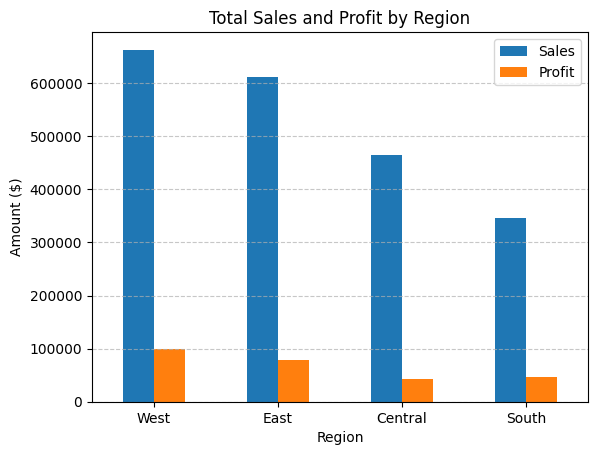

In [3]:
import matplotlib.pyplot as plt

region_summary = (
    trans_raw.groupby('Region')[['Sales', 'Profit']]
    .sum()
    .sort_values('Sales', ascending=False)
)

plt.figure(figsize=(8,5))
region_summary.plot(kind='bar', rot=0)
plt.title('Total Sales and Profit by Region')
plt.ylabel('Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The plot shows that the West and East regions have the highest sales volumes, but profit distribution may vary due to differences in discount strategies or shipping costs.